In [12]:
# import all necessary libraries
import numpy as np
import pandas as pd
import itertools
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import os
import sys
import git

In [13]:
### Extracting Data
# define the file paths
base_root = git.Repo('.', search_parent_directories=True).working_tree_dir
base_input = base_root + '\\Input & Output\\Input\\'
base_output = base_root + '\\Input & Output\\Output\\'

anaylsis_input = base_input + 'Post Analysis\\'
anaylsis_output = base_output + 'Post Analysis\\'

# read in all data fields as dictionary; key: sheet name, value: sheet dataframe
df = pd.read_excel(anaylsis_output + 'all_field_data_daily.xlsx', sheet_name = 'All Data Fields')

In [14]:
# Define the features
ontario_supply = 'MW Amount'
toronto_temp = 'Temperature'
gas_price = 'Gas Price'
month = 'Month'

toront_demand = 'Toronto Demand'
ontario_demand = 'Ontario Demand'
toronto_price = 'Price'	

feature_lst = df.columns.tolist()
feature_lst.remove(toront_demand)
feature_lst.remove(toronto_price)
feature_lst.remove(ontario_demand)
feature_lst.remove('Date')

# feature_lst = [ontario_supply, toronto_temp, gas_price, month]
df = df[[toront_demand, toronto_price] + feature_lst]

X = df.drop(columns=[toronto_price, toront_demand])
print("The following are my features")
print(X.columns)

# creating target columns
# y = df[toronto_price].values
y = df[toront_demand].values

The following are my features
Index(['MW Amount', 'Gas Price', 'Temperature', 'Relative Humidity',
       'Dew Point', 'Wind Speed', 'Sea Level Pressure', 'HDD 15.5', 'CDD 15.5',
       'HDD 18', 'CDD 18', 'Precipitation (mm)', 'Year', 'Month', 'Day',
       'DayOfWeek', 'IsWeekend', 'TempSquared', 'PrevDayDemand', 'Population'],
      dtype='object')


In [15]:
### --- Data Preprocessing --- 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaler (for X)
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# Target scaler (for y)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

In [16]:
### --- Defining Hyperparameters ---
size1 = [5, 25, 50, 100, 250]
size2 = [5, 25, 50, 100, 250]
size3 = [5, 25, 50, 100, 250]
size4 = [5, 25, 50, 100, 250]
shapes = (
    list(itertools.product(size1, repeat=1))
    + list(itertools.product(size2, repeat=2))
    + list(itertools.product(size3, repeat=3))
    + list(itertools.product(size4, repeat=4))
)

# create a dictionary from the hyperparameter grid
param_grid = dict(
	hidden_layer_sizes = shapes,
	learning_rate = ['constant', 'adaptive', 'invscaling'],
	batch_size = [4, 8, 16, 32, 64, 128], 
    alpha = [0.1, 0.01, 0.001], 
    activation = ['tanh', 'relu']
)

In [17]:
### --- Train a neural network ---
model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    alpha=0.001,
    learning_rate='adaptive',
    batch_size=32,
    solver='adam',
    max_iter=10000,
    random_state=42
)

# tunning hyperparameters
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=3, param_distributions=param_grid, scoring="r2")
searchResults = searcher.fit(X_train_scaled, y_train_scaled)

# summarize grid search information
bestScore = searchResults.best_score_
bestParams = searchResults.best_params_
# Get the best model
model = best_xgb_model = searchResults.best_estimator_
print("[INFO] best score is {:.2f} using {}".format(bestScore, bestParams))
print()

[INFO] best score is 0.98 using {'learning_rate': 'constant', 'hidden_layer_sizes': (50, 100, 5, 50), 'batch_size': 16, 'alpha': 0.01, 'activation': 'relu'}



In [18]:
### Evaluate the mode
# get the prediction results from the testing set
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# compare the predictions with the testing target
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
scores = cross_val_score(model, X_train_scaled, y_train_scaled, scoring='neg_mean_squared_error', cv=5)

print(f"CV Mean MSE: {-np.mean(scores):.2f}")
print(f"Mean Squared Error (MSE) with testing set: {mse:.2f}")
print(f"R-squared (R2) with testing set: {r2:.2f}")

print()

CV Mean MSE: 0.02
Mean Squared Error (MSE) with testing set: 75578.32
R-squared (R2) with testing set: 0.96



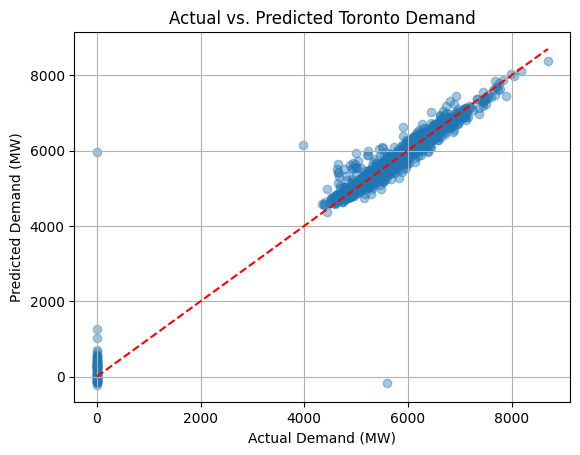

In [19]:
### Visulizing the model
# errors = y_test - y_pred
# plt.hist(errors, bins=50)
# plt.title("Prediction Errors")
# plt.xlabel("Error (MW)")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.show()

plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Demand (MW)")
plt.ylabel("Predicted Demand (MW)")
plt.title("Actual vs. Predicted Toronto Demand")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.grid(True)
plt.show()

In [20]:
### --- Prediction ---
predict_data = [15707.64651, 5.32, 11.71, 84.8, 9.1, 15.62, 100.98, 4.4, 0.6, 4.8, 0, 7.4, 2003, 5, 1, 3, 0, 137.1241, 0, 4861000]
# predict_data = [15707.64651, 11.71, 5.32, 5]
# print(len(predict_data))
# print(len(feature_lst))
# print(feature_lst)
predict_df = pd.DataFrame(
    [predict_data], 
    columns = feature_lst
)

# Scale the predicting features
predict_df_scaled = x_scaler.transform(predict_df)

# Predict using the trainned model
predicted_value_scaled = model.predict(predict_df_scaled)

# Inverse transform to get real-world demand value
predicted_value = y_scaler.inverse_transform(
    predicted_value_scaled.reshape(-1, 1)
).ravel()[0]


print('Prediction Input Data: ' + str(predict_data))
print(f"Prediction for new data: {predicted_value}")

Prediction Input Data: [15707.64651, 5.32, 11.71, 84.8, 9.1, 15.62, 100.98, 4.4, 0.6, 4.8, 0, 7.4, 2003, 5, 1, 3, 0, 137.1241, 0, 4861000]
Prediction for new data: 4080.5787678113147
